In [1]:
# source("/Users/farbood/Research/hierarchical_segmentation/R/annotator_feature_anova.R", print=TRUE)
# October 28, 2016
# ANOVA for hierarhical segmentation paper, McFee et al., Front. Psychol.

library(ez)
library(lme4)
library(nlme)
library(multcomp)
library(pbkrtest)

options(contrasts=c("contr.sum","contr.poly"))

Loading required package: Matrix

Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList

Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Loading required package: MASS

Attaching package: ‘TH.data’

The following object is masked from ‘package:MASS’:

    geyser



In [11]:
dataM <- read.csv(file="../data/SPAM_annotator_track_feature.csv",head=TRUE, sep=",");
colnames(dataM) <- c('annotator_id', 'track_id', 'feature', 'y', 'featureID');

dataM <- within(dataM, {
  annotator <- factor(annotator_id)
  track <- factor(track_id)
  feature <- factor(feature)
  featureID <- factor(featureID) # not used
})

In [13]:
cat('\n#################################################\n')
cat('#      TWO-WAY REPEATED-MEASURES ANOVAS         #\n')
cat('#################################################\n')

# ANOVA using aov
cat('>>>> AOV OUTPUT <<<<\n')
aovM <- aov(y ~ annotator * feature + Error(track/(annotator*feature)), data=dataM)
summary(aovM)

# ANOVA again using ezANOVA
cat('\n>>>>> ezANOVA RESULTS <<<<\n')
ezM = ezANOVA(data=dataM, dv=.(y), within=.(annotator,feature), wid=.(track), detailed=TRUE)
ezM$ANOVA$MSE = ezM$ANOVA$SSd/ezM$ANOVA$DFd
MSE = ezM$ANOVA$MSE
print(ezM)


#################################################
#      TWO-WAY REPEATED-MEASURES ANOVAS         #
#################################################
>>>> AOV OUTPUT <<<<



Error: track
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 49   6.65  0.1357               

Error: track:annotator
           Df Sum Sq  Mean Sq F value Pr(>F)   
annotator   4 0.0932 0.023303   3.435 0.0097 **
Residuals 196 1.3296 0.006784                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: track:feature
           Df Sum Sq Mean Sq F value   Pr(>F)    
feature     3  2.559  0.8530   28.33 1.63e-14 ***
Residuals 147  4.426  0.0301                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: track:annotator:feature
                   Df Sum Sq  Mean Sq F value   Pr(>F)    
annotator:feature  12 0.0705 0.005876   3.002 0.000425 ***
Residuals         588 1.1508 0.001957                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


>>>>> ezANOVA RESULTS <<<<
$ANOVA
             Effect DFn DFd         SSn      SSd          F            p p<.05
1       (Intercept)   1  49 39.14610515 6.650068 288.442037 3.599029e-22     *
2         annotator   4 196  0.09321386 1.329621   3.435175 9.696345e-03     *
3           feature   3 147  2.55904632 4.426380  28.328625 1.625942e-14     *
4 annotator:feature  12 588  0.07050748 1.150761   3.002246 4.254174e-04     *
          ges         MSE
1 0.742768980 0.135715673
2 0.006828832 0.006783778
3 0.158790395 0.030111431
4 0.005173973 0.001957076

$`Mauchly's Test for Sphericity`
             Effect          W            p p<.05
2         annotator 0.52123828 3.118209e-04     *
3           feature 0.63628469 6.331132e-04     *
4 annotator:feature 0.03748067 3.228603e-06     *

$`Sphericity Corrections`
             Effect       GGe        p[GG] p[GG]<.05       HFe        p[HF]
2         annotator 0.7288500 1.968471e-02         * 0.7799243 1.720898e-02
3           feature 0.79572

Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”

Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”

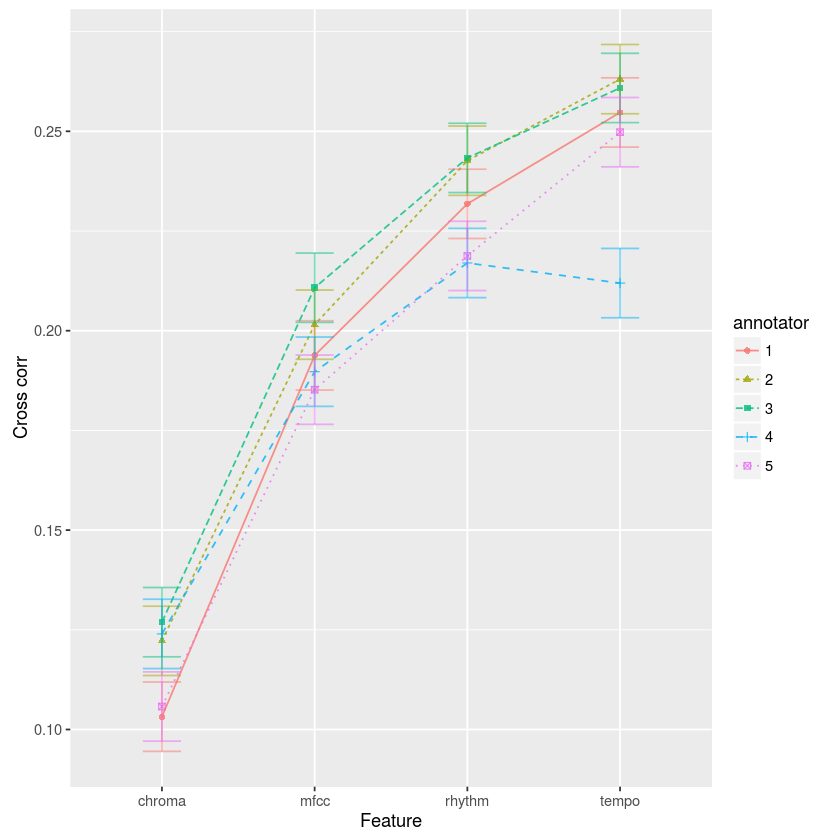

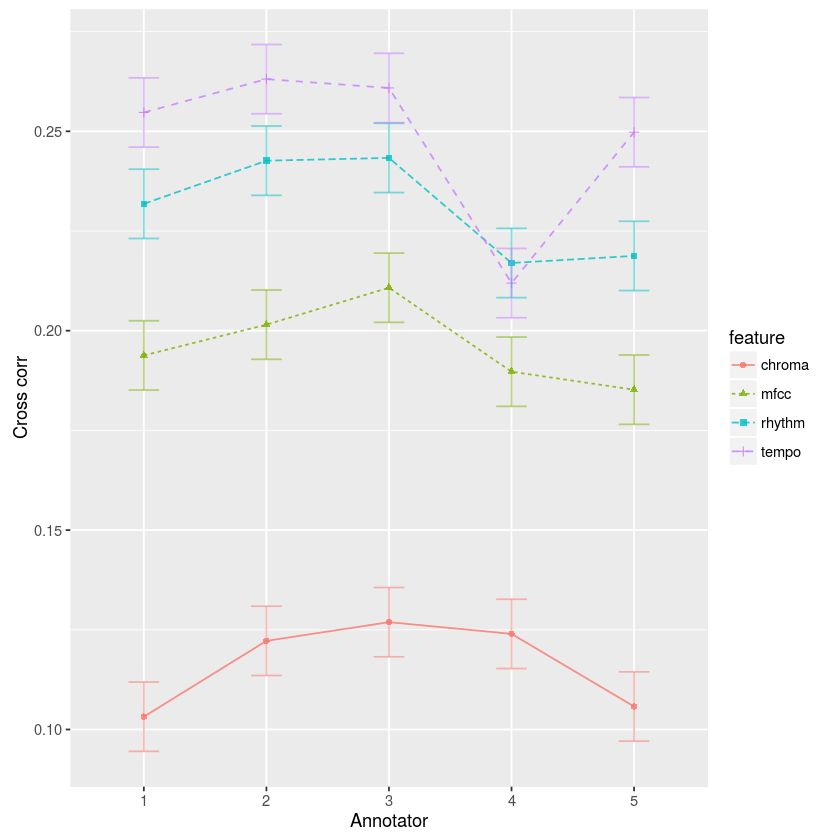

In [14]:
# plot group means
ezPlot(data=dataM, dv=.(y), wid=.(track), do_bars = TRUE, within=.(feature,annotator), split=.(annotator),  
       x=.(feature),x_lab=c("Feature"), y_lab = "Cross corr")

ezPlot(data=dataM, dv=.(y), wid=.(track), do_bars = TRUE, within=.(feature,annotator), split=.(feature),  
       x=.(annotator),x_lab=c("Annotator"), y_lab = "Cross corr")

In [17]:
# ezANOVA results show that Mauchly's test is significant (sphericity violated) so apply corrections
cat("\n>>> GREENHOUSE-GEISSER AND HUYNH-FELDT CORRECTIONS (H-F applied when GG > .75) <<<\n")
ep_anno = ezM$Sphericity[1,"GGe"]
ep_feature = ezM$Sphericity[2,"GGe"]
ep_inter = ezM$Sphericity[3,"GGe"]

# use H-F correction if G-G epsilon > .75, otherwise apply G-G correction to be conservative
if (ep_anno > .75) {
    ep_anno = ezM$Sphericity[1,"HFe"]
}
if (ep_feature > .75) {
    ep_feature = ezM$Sphericity[2,"HFe"]
}
if (ep_inter > .75) {
    ep_inter = ezM$Sphericity[3,"HFe"]
}

# calculate degrees of freedom updated with correction
df1_anno = ezM$ANOVA[2,"DFn"]*ep_anno
df2_anno = ezM$ANOVA[2,"DFd"]*ep_anno

df1_feature = ezM$ANOVA[3,"DFn"]*ep_feature
df2_feature = ezM$ANOVA[3,"DFd"]*ep_feature

df1_inter = ezM$ANOVA[4,"DFn"]*ep_inter
df2_inter =  ezM$ANOVA[4,"DFd"]*ep_inter

F_anno = ezM$ANOVA[2,"F"]
F_feature = ezM$ANOVA[3,"F"]
F_inter = ezM$ANOVA[4,"F"]

p_anno = 1 - pf(F_anno, df1_anno, df2_anno);
p_feature = 1 - pf(F_feature, df1_feature, df2_feature);
p_inter = 1 - pf(F_inter, df1_inter, df2_inter);

# calcuate effect size
eta_anno = ezM$ANOVA[2,"ges"]
eta_feature = ezM$ANOVA[3,"ges"]
eta_inter = ezM$ANOVA[4,"ges"]
etap_anno = (F_anno * df1_anno)/((F_anno * df1_anno) + df2_anno)
etap_feature = (F_feature * df1_feature)/((F_feature * df1_feature) + df2_feature)
etap_inter = (F_inter * df1_inter)/((F_inter * df1_inter) + df2_inter)

cat("   ANNOTATOR : F(", df1_anno, ",", df2_anno, ") = ", F_anno, "; p =", p_anno, "; gen eta^2 =", eta_anno, "; part eta^2 =", etap_anno, "; MSE = ", MSE[2], "\n")
cat("   FEATURE   : F(", df1_feature, ",", df2_feature, ") = ", F_feature, "; p =", p_feature, "; gen eta^2 =", eta_feature, "; part eta^2 =", etap_feature, "; MSE = ", MSE[3], "\n")
cat("   INTERACT  : F(", df1_inter, ",", df2_inter, ") = ", F_inter, "; p =", p_inter, "; gen eta^2 =", eta_inter, "; part eta^2 =", etap_inter, "; MSE = ", MSE[4], "\n")

cat('\n>>>> MULTIPLE COMPARISONS (TUKEY) <<<\n')
lmerM = lmer(y ~ annotator + feature + annotator:feature + (1 | track), data=dataM)
print(summary(glht(lmerM, linfct = mcp(annotator = "Tukey"))))
print(summary(glht(lmerM, linfct = mcp(feature = "Tukey"))))

#annotator_feature_anova.R
#Displaying anova_output.txt.


>>> GREENHOUSE-GEISSER AND HUYNH-FELDT CORRECTIONS (H-F applied when GG > .75) <<<
   ANNOTATOR : F( 2.9154 , 142.8546 ) =  3.435175 ; p = 0.01968471 ; gen eta^2 = 0.006828832 ; part eta^2 = 0.06551279 ; MSE =  0.006783778 
   FEATURE   : F( 2.517741 , 123.3693 ) =  28.32863 ; p = 1.498912e-12 ; gen eta^2 = 0.1587904 ; part eta^2 = 0.3663407 ; MSE =  0.03011143 
   INTERACT  : F( 8.264794 , 404.9749 ) =  3.002246 ; p = 0.002460308 ; gen eta^2 = 0.005173973 ; part eta^2 = 0.057733 ; MSE =  0.001957076 

>>>> MULTIPLE COMPARISONS (TUKEY) <<<


Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = y ~ annotator + feature + annotator:feature + 
    (1 | track), data = dataM)

Linear Hypotheses:
            Estimate Std. Error z value Pr(>|z|)  
2 - 1 == 0  0.011478   0.008613   1.333   0.6708  
3 - 1 == 0  0.014587   0.008613   1.694   0.4379  
4 - 1 == 0 -0.010233   0.008613  -1.188   0.7583  
5 - 1 == 0 -0.006010   0.008613  -0.698   0.9570  
3 - 2 == 0  0.003109   0.008613   0.361   0.9964  
4 - 2 == 0 -0.021711   0.008613  -2.521   0.0861 .
5 - 2 == 0 -0.017488   0.008613  -2.030   0.2514  
4 - 3 == 0 -0.024820   0.008613  -2.882   0.0323 *
5 - 3 == 0 -0.020597   0.008613  -2.391   0.1177  
5 - 4 == 0  0.004222   0.008613   0.490   0.9883  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = y ~ annotator + feature + annotator:feature + 
    (1 | track), data = dataM)

Linear Hypotheses:
                     Estimate Std. Error z value Pr(>|z|)    
mfcc - chroma == 0   0.079786   0.007704  10.357   <0.001 ***
rhythm - chroma == 0 0.114284   0.007704  14.835   <0.001 ***
tempo - chroma == 0  0.131662   0.007704  17.090   <0.001 ***
rhythm - mfcc == 0   0.034498   0.007704   4.478   <0.001 ***
tempo - mfcc == 0    0.051876   0.007704   6.734   <0.001 ***
tempo - rhythm == 0  0.017378   0.007704   2.256    0.109    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)

